# Compare predictions
predictions stored as csv submissions

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)
    
os.environ['PRETRAINED_MODELS'] = '../../../pretrained-models.pytorch/'
os.environ['IGNITE_PATH'] = '../../../pytorch-ignite-master/'
ignite_path = os.environ['IGNITE_PATH']
if ignite_path not in sys.path:
    sys.path.append(ignite_path)

In [37]:
from common.dataflow import get_test_df, get_image, get_index, get_inc_angle, get_target

def is_generated(a):
    return a * 1e4 - int(a * 1e4) > 1e-5


test_df = get_test_df()
test_df['generated'] = test_df['inc_angle'].apply(is_generated)

from common.dataflow import IcebergDataset
norm_b1 = IcebergDataset.norm_b1
norm_b2 = IcebergDataset.norm_b2

from functools import partial

def get_norm_band(b, f=norm_b1):
    return f(np.array(b[0]), b[1]).tolist()

test_df.loc[:, "nband_1"] = test_df[['band_1', 'inc_angle']].apply(partial(get_norm_band, f=norm_b1), axis=1)
test_df.loc[:, "nband_2"] = test_df[['band_2', 'inc_angle']].apply(partial(get_norm_band, f=norm_b2), axis=1)

test_df.loc[:, 'max_b1'] = test_df['nband_1'].apply(np.max)
test_df.loc[:, 'max_b2'] = test_df['nband_2'].apply(np.max)

In [38]:
output_path = os.path.join("..", "output")
results_path = os.path.join("..", "results")

In [39]:
!ls {results_path}

submission__avg_models__20171210_0000_predictions_config_kfolds_inceptionv4_20171209_1500.csv
submission__avg_models__20171217_1845_predictions_config_kfolds_vgg13_angle_stats_20171217_1803.csv
submission__avg_models__predictions_config_kfolds_densenet_20171204_1300_20171204_1239.csv
submission__avg_models__predictions_config_kfolds_densenet_20171204_1300_20171204_1239_proba_thresholds_0.03_0.97.csv
submission__avg_models__predictions_config_kfolds_inceptionv4_20171203_1100_20171203_2138.csv
submission__avg_models__predictions_config_kfolds_inceptionv4_20171204_0900_20171204_0748.csv
submission__avg_models__predictions_config_kfolds_vgg_v0_20171209_1100_20171209_1019.csv
submission__avg_models__predictions_config_kfolds_vgg_v0_20171209_1200_20171209_1114.csv
submission__avg_models__predictions_config_single_network_20171203_1500_20171208_1809.csv
submission__xbg_12_features_ccrop32_inc_norm_val=0.2645_no_proba_thresholds.csv
submission__xbg_12_features_inc_norm_val=0.1191_no_proba_thre

In [40]:
filenames = [
    ("vgg_v0_20171209_1200", results_path, "submission__avg_models__predictions_config_kfolds_vgg_v0_20171209_1200_20171209_1114.csv"),
    ("inceptionv4_20171209_1500", results_path, "submission__avg_models__20171210_0000_predictions_config_kfolds_inceptionv4_20171209_1500.csv"),
#     ("xbg_12_features", results_path, "submission__xbg_12_features_val=0.258_no_proba_thresholds.csv"),    
    ("densenet_20171204_1300", results_path, "submission__avg_models__predictions_config_kfolds_densenet_20171204_1300_20171204_1239.csv"),
    ("xbg_12_features_aug", results_path, "submission__xbg_12_features_val=0.1248_no_proba_thresholds.csv"),        
#     ("xbg_12_features_aug_inc_norm", results_path, "submission__xbg_12_features_inc_norm_val=0.1191_no_proba_thresholds.csv"),
#     ("xbg_12_features_ccrop32_inc_norm", results_path, "submission__xbg_12_features_ccrop32_inc_norm_val=0.2645_no_proba_thresholds.csv"),
    ("vgg13_angle_stats_20171217_1803", results_path, "submission__avg_models__20171217_1845_predictions_config_kfolds_vgg13_angle_stats_20171217_1803.csv"),
]

df = pd.DataFrame()
n, p, f = filenames[0]
_df = pd.read_csv(os.path.join(results_path, f))
df['id'] = _df['id']
df[n] = _df['is_iceberg']

for n, p, f in filenames[1:]:
    _df = pd.read_csv(os.path.join(p, f))
    assert (df['id'] == _df['id']).all()
    df[n] = _df['is_iceberg']

In [41]:
df2 = df[test_df['generated'] == False]

In [42]:
df2.corr()

,vgg_v0_20171209_1200,inceptionv4_20171209_1500,densenet_20171204_1300,xbg_12_features_aug,vgg13_angle_stats_20171217_1803
vgg_v0_20171209_1200,1.000000,0.980160,0.907066,0.819477,0.975262
inceptionv4_20171209_1500,0.980160,1.000000,0.918581,0.819207,0.973154
densenet_20171204_1300,0.907066,0.918581,1.000000,0.863774,0.926583
xbg_12_features_aug,0.819477,0.819207,0.863774,1.000000,0.830995
vgg13_angle_stats_20171217_1803,0.975262,0.973154,0.926583,0.830995,1.000000


In [43]:
cols = df2.columns.values[1:]

In [44]:
df2.columns
# df2.head()

Index(['id', 'vgg_v0_20171209_1200', 'inceptionv4_20171209_1500',
       'densenet_20171204_1300', 'xbg_12_features_aug',
       'vgg13_angle_stats_20171217_1803'],
      dtype='object')

In [45]:
df2.loc[:, 'predictions_std'] = df2[cols].apply(np.std, axis=1)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
df3 = df2[df2['predictions_std'] > 0.1]
df3.head(20)

,id,vgg_v0_20171209_1200,inceptionv4_20171209_1500,densenet_20171204_1300,xbg_12_features_aug,vgg13_angle_stats_20171217_1803,predictions_std
15,f156976f,0.002623,0.008822,0.005633,0.348565,0.005063,0.137226
21,b9087b9e,0.242942,0.188590,0.250608,0.769057,0.335116,0.211168
26,bbad5958,0.048006,0.084427,0.058342,0.471929,0.038203,0.166588
36,e01a3c92,0.044961,0.026014,0.070362,0.733288,0.047248,0.274818
45,636cfbb7,0.632722,0.551831,0.250785,0.990106,0.541597,0.236947
56,b3d569e3,0.000734,0.000879,0.075559,0.678353,0.007219,0.264413
57,6c538c5b,0.031688,0.018053,0.088807,0.456698,0.015689,0.169345
66,5c6c71b1,0.212925,0.213664,0.420843,0.134371,0.490407,0.136508
73,16646a17,0.992301,0.972620,0.970986,0.638167,0.990828,0.137692
81,1ac8bb92,0.936292,0.980606,0.949818,0.590489,0.959497,0.147137


In [47]:
from common.dataflow_visu_utils import display_image

In [48]:
n_samples = len(df3)
data_ids = np.empty((n_samples,), dtype=object)
data_ids[:] = df3['id'].values

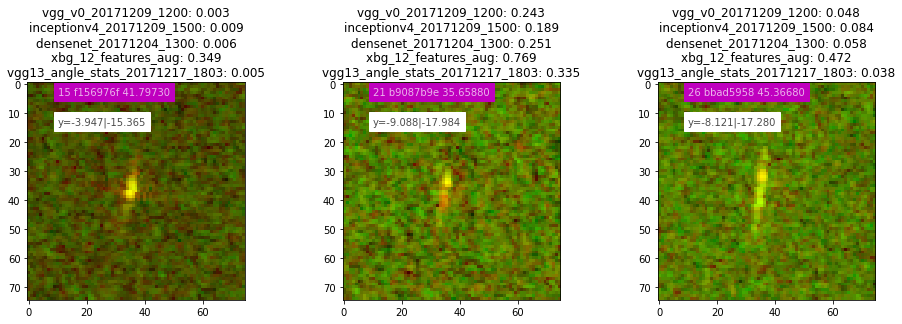

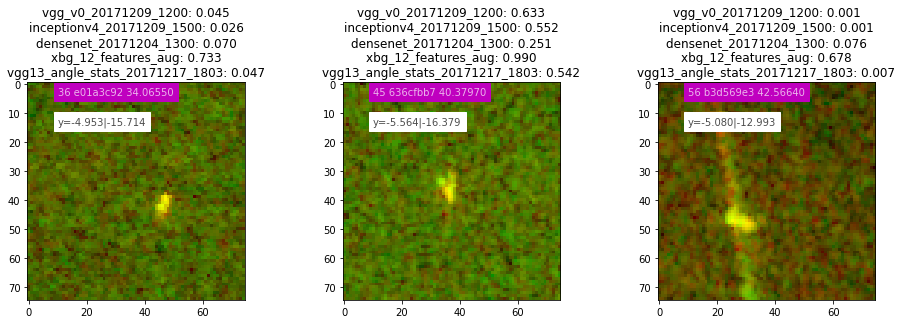

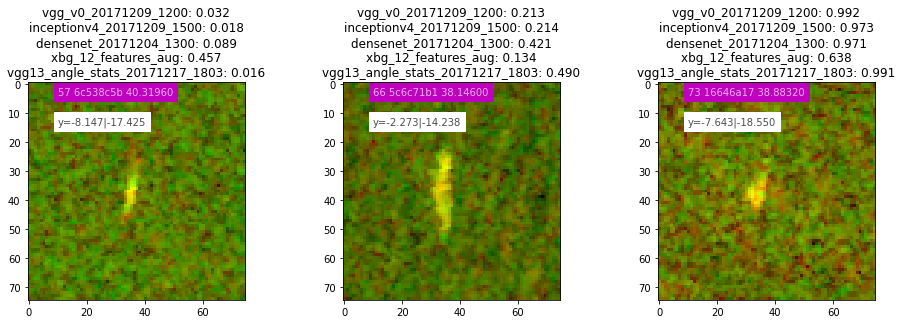

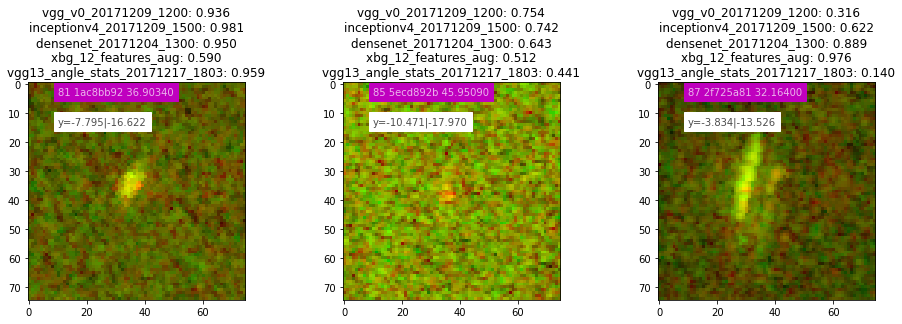

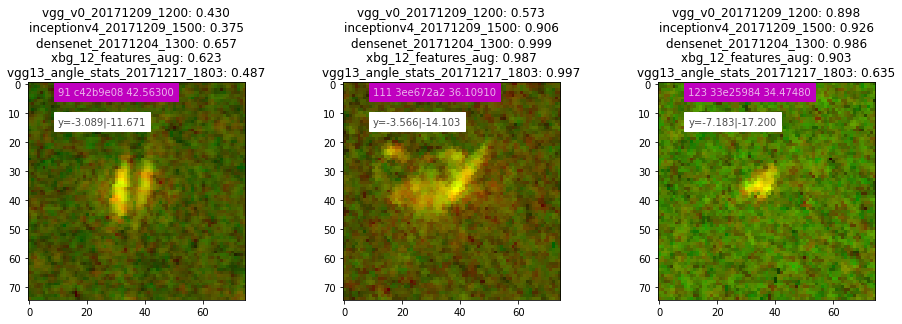

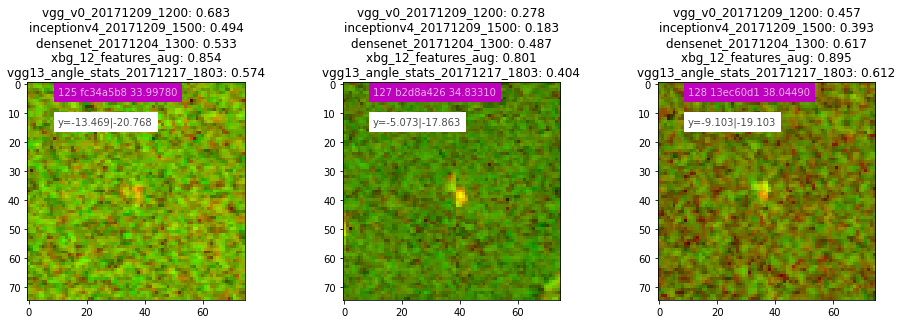

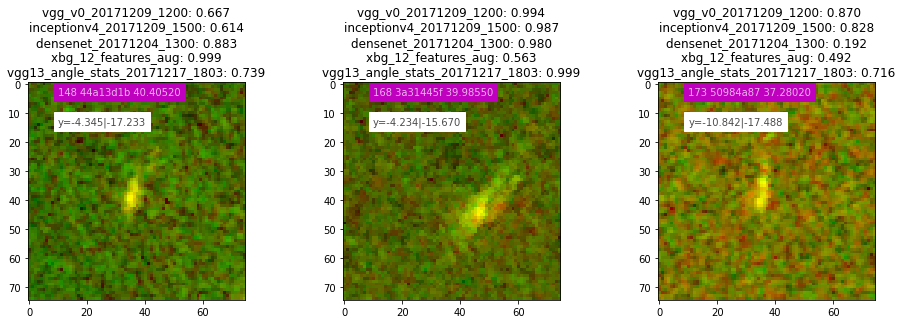

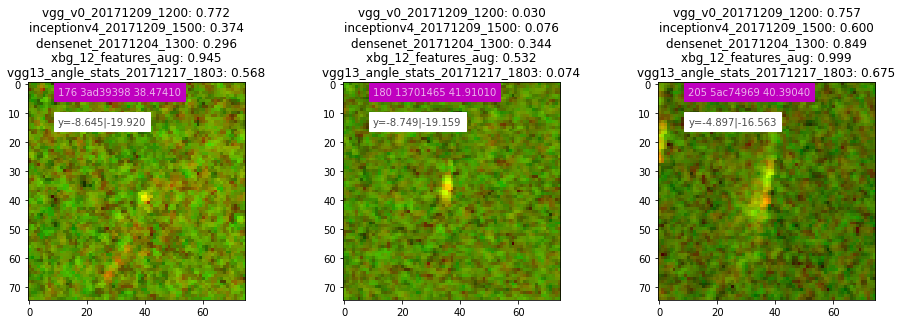

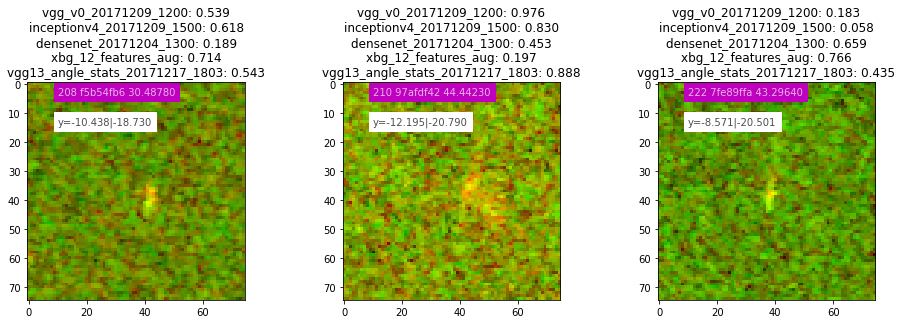

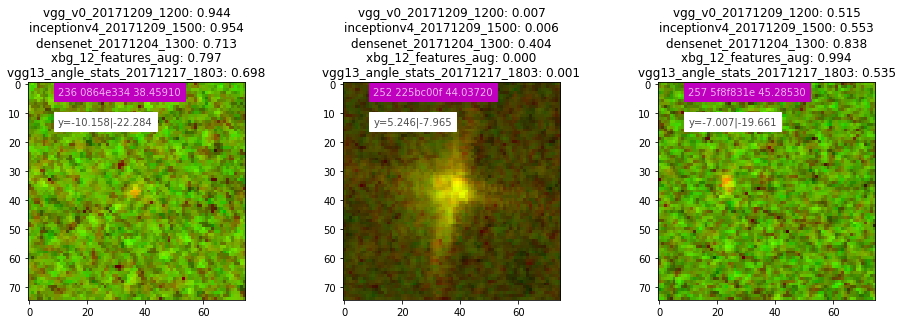

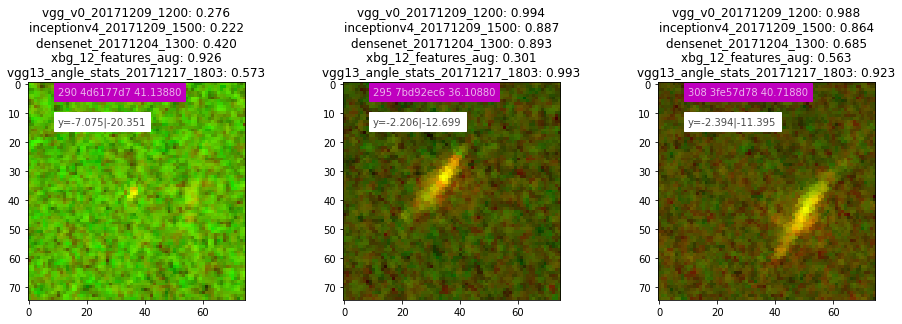

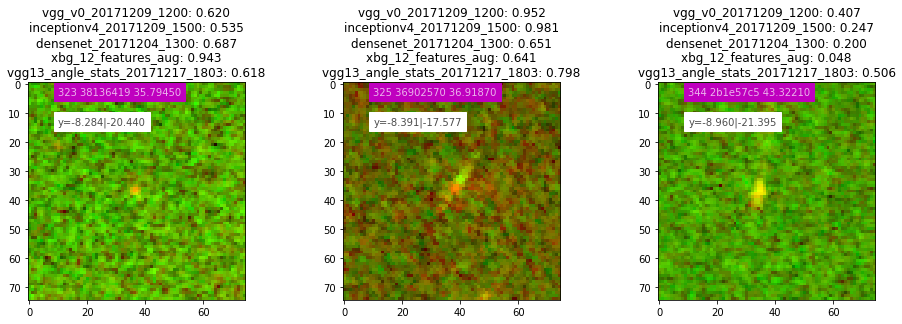

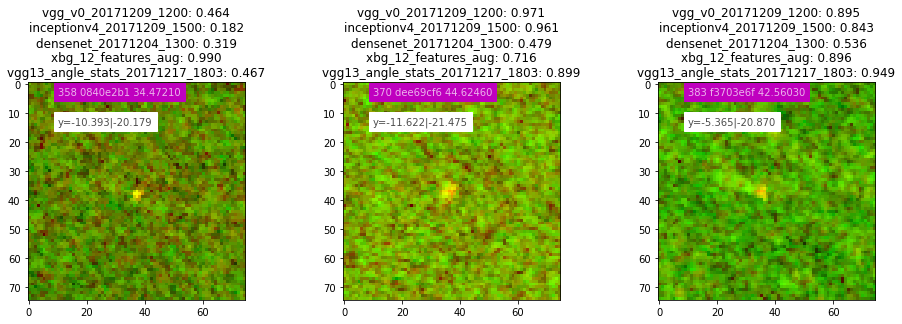

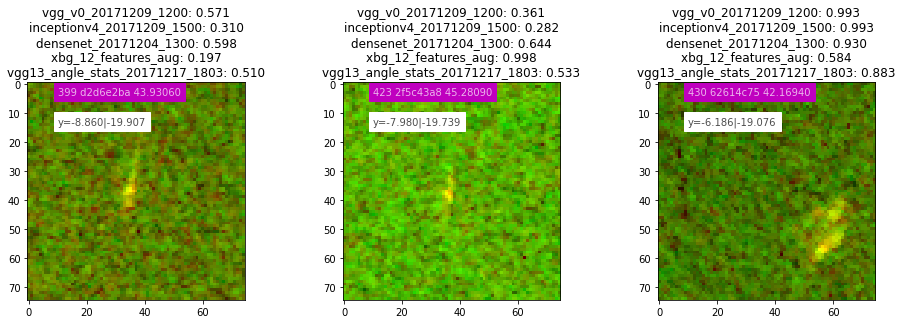

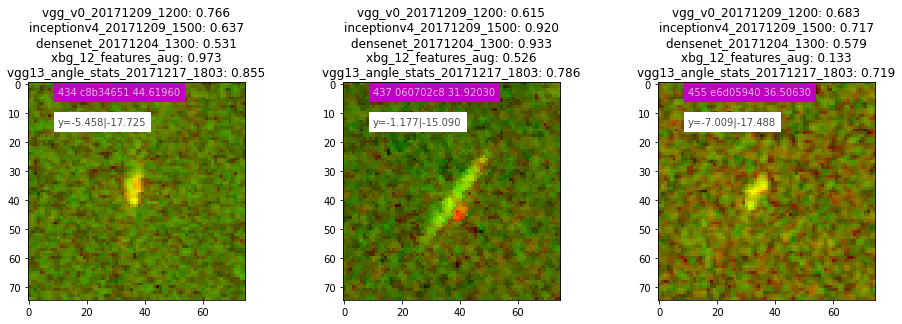

In [53]:
n_cols = 3

for i, image_id in enumerate(data_ids[:45]):
    
    if i % n_cols == 0:
        plt.figure(figsize=(16, 4))
        
    index = get_index(image_id, df3)
    x = get_image(index, test_df)
    inc_angle = get_inc_angle(index, test_df)
    max_b1 = test_df.loc[index, 'max_b1']
    max_b2 = test_df.loc[index, 'max_b2']
    
    ax = plt.subplot(1, n_cols, i % n_cols + 1)
    title = "\n".join(["{0}: {1:.3f}".format(c, v) for c, v in zip(cols, df3.loc[index, cols].values)])
    ax.set_title(title)
    display_image(ax, x, index, image_id, inc_angle, "{0:.3f}|{1:.3f}".format(max_b1, max_b2))

In [60]:
len(df2.index), len(test_df.index)

(3183, 8424)

In [70]:
df[(df['vgg_v0_20171209_1200'] > 0.1) & (test_df['max_b1'] > 0.0) & (test_df['generated'] == False)].head(20)

,id,vgg_v0_20171209_1200,inceptionv4_20171209_1500,densenet_20171204_1300,xbg_12_features_aug,vgg13_angle_stats_20171217_1803
462,0ebcb731,0.996634,0.971571,0.880284,0.623184,0.978823
814,b0a3e728,0.110001,0.282076,0.627914,0.071409,0.058073
888,dc97b587,0.168010,0.193077,0.187523,0.006835,0.237590
1746,65f79253,0.995176,0.984781,0.983232,0.935503,0.995072
1779,3c72f288,0.949178,0.939808,0.746842,0.469575,0.942659
2599,5a17b824,0.980894,0.869359,0.381997,0.088290,0.804251
2989,6a5c8da8,0.931224,0.764592,0.836271,0.019371,0.960351
3273,a401ce15,0.241380,0.117906,0.017865,0.002840,0.177477
5230,dd981ea6,0.115725,0.103239,0.004097,0.000983,0.332287
6478,6dc06e16,0.129485,0.038784,0.000209,0.005716,0.017077


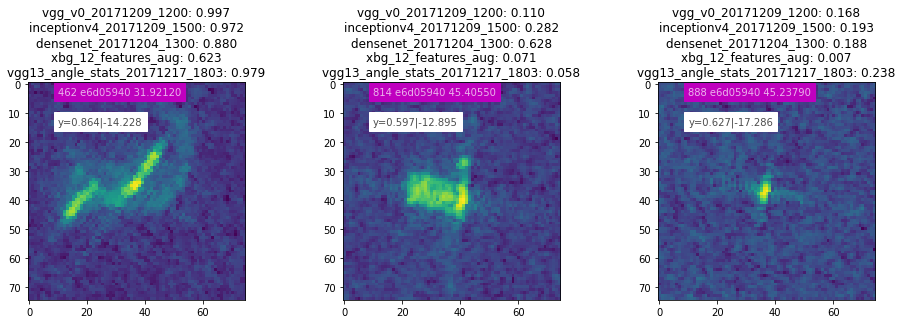

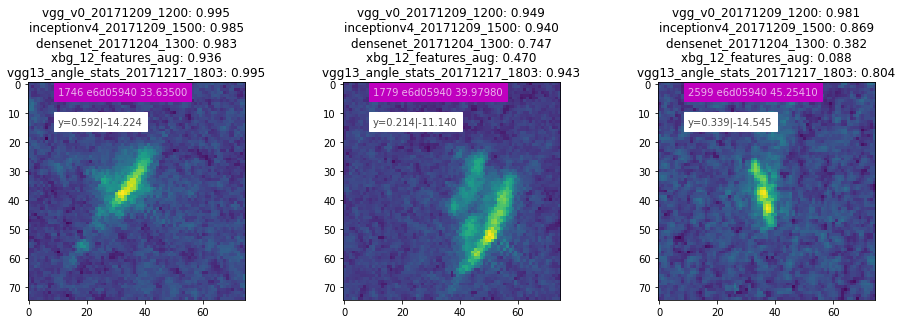

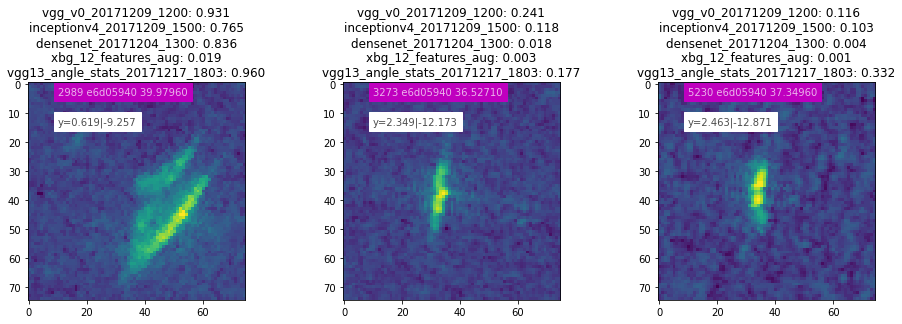

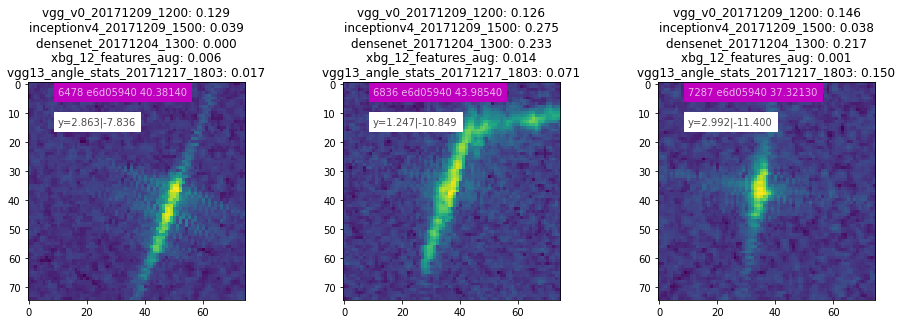

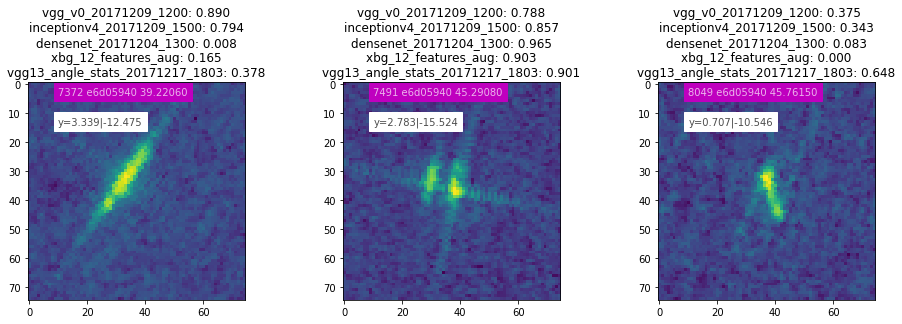

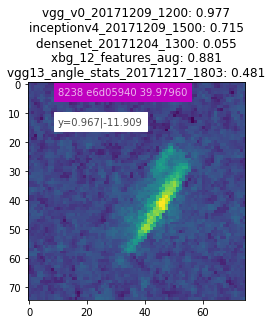

In [73]:
n_cols = 3

indices = test_df[(test_df['max_b1'] > 0.0) & (df['vgg_v0_20171209_1200'] > 0.1) & (test_df['generated'] == False)].index

for i, index in enumerate(indices[:40]):
    
    if i % n_cols == 0:
        plt.figure(figsize=(16, 4))
        
    x = get_image(index, test_df)
    inc_angle = get_inc_angle(index, test_df)
    max_b1 = test_df.loc[index, 'max_b1']
    max_b2 = test_df.loc[index, 'max_b2']
    
    ax = plt.subplot(1, n_cols, i % n_cols + 1)
    title = "\n".join(["{0}: {1:.3f}".format(c, v) for c, v in zip(cols, df.loc[index, cols].values)])
    ax.set_title(title)
    display_image(ax, x[:, :, 0] + x[:, :, 1], index, image_id, inc_angle, "{0:.3f}|{1:.3f}".format(max_b1, max_b2))
    
    

In [117]:
from mpl_toolkits.axes_grid1 import ImageGrid
from common.dataflow_visu_utils import display_image

In [120]:
n_samples = len(df3)
n_classes = 1
y_probas = np.zeros((n_samples, n_classes), dtype=np.float32)
data_ids = np.empty((n_samples,), dtype=object)

data_ids[:] = df3['id'].values
y_probas[:, 0] = df3['vgg_v0_20171209_1200'].values

In [121]:
# class_index = 0
# gt_threshold = 0.93
# mn_thresholds = (0.45, 0.55)
# lt_threshold = 0.07

# class_probas = y_probas[:, class_index]

# indices_gt = np.where(class_probas > gt_threshold)[0]
# indices_mn = np.where((class_probas < mn_thresholds[1]) & (class_probas > mn_thresholds[0]))[0]
# indices_lt =np.where(class_probas < lt_threshold)[0]

In [122]:
def display_images(data_ids, y_probas, df, nx=10, max_ny=10):    
    ll = len(data_ids)
    ny = int(ll / nx) + 1
    n_parts = int(ny / max_ny) + 1
    for k in range(n_parts):
        _ny = min(max_ny, ny - max_ny * k)
        fig = plt.figure(figsize=(24,24))
        grid = ImageGrid(fig, 111, nrows_ncols=(_ny, nx), axes_pad=0.05)
        start = nx * max_ny * k
        end = min(start + nx * _ny, ll)
        for count, i in enumerate(range(start, end)):
            image_id = data_ids[i]
            index = get_index(image_id, df)
            x = get_image(index, df)                
            y = y_probas[i]
            inc_angle = get_inc_angle(index, df)        
            ax = grid[count]
            display_image(ax, x, index, image_id, inc_angle, y)

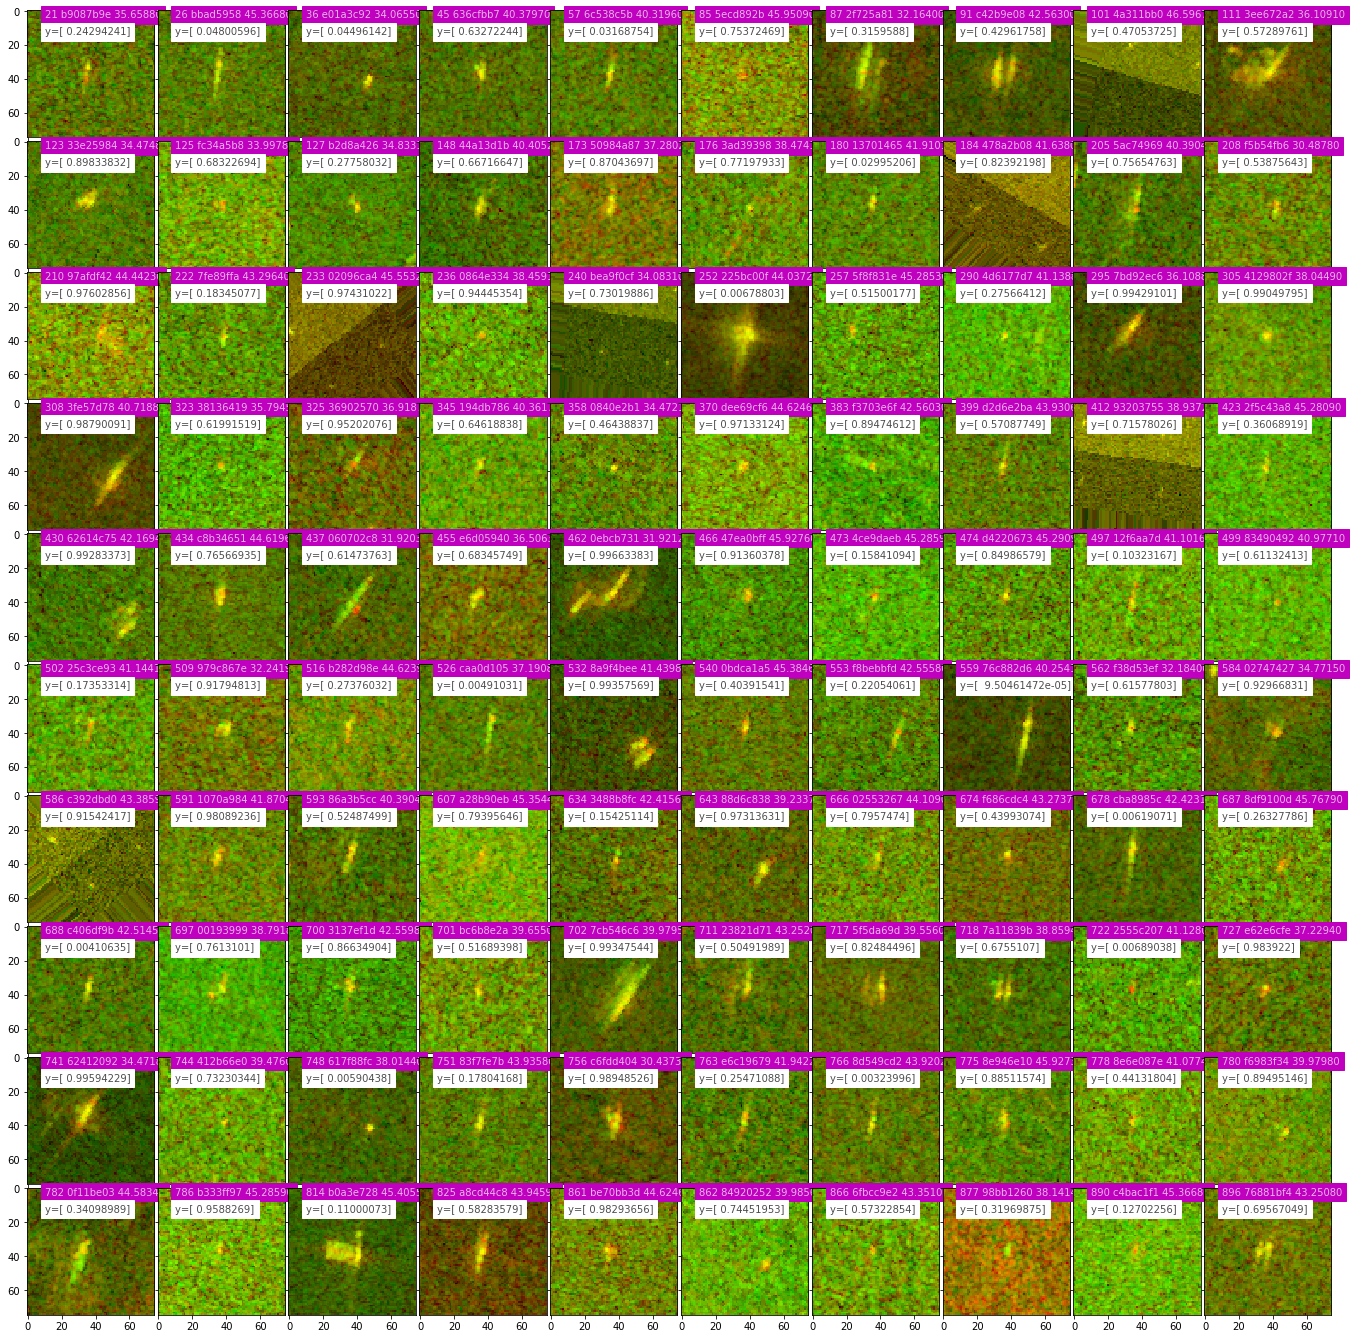

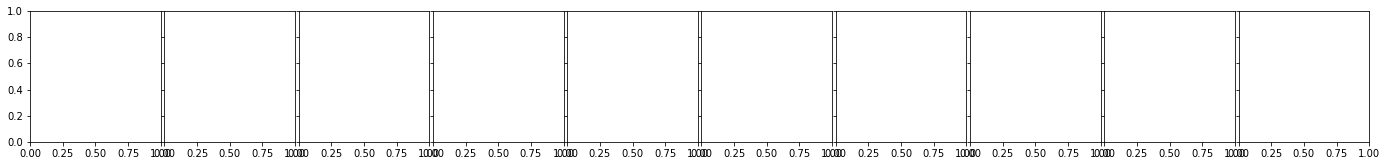

In [125]:
display_images(data_ids[:100], y_probas[:100, :], test_df)